In [1]:
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR/ps.fungi")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5670 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 102 sample variables ]
tax_table()   Taxonomy Table:    [ 5670 taxa by 18 taxonomic ranks ]

In [3]:
B1=50
B2=200
B3=400
sample_data(ps)$RBR_Cat = ifelse(sample_data(ps)$RBR<B1,"Unburned",
                                 ifelse(sample_data(ps)$RBR<B2,"Low",
                                       ifelse(sample_data(ps)$RBR<B3,"Moderate","High")))
sample_data(ps)$RBR_Cat

[1] "High"     "Moderate" "Low"      "Low"      "Moderate" "Moderate"
  [7] "Low"      "Low"      "Low"      "Low"      "Unburned" "Low"     
 [13] "Low"      "Low"      "High"     "High"     "Moderate" "High"    
 [19] "High"     "Low"      "Low"      "Low"      "High"     "High"    
 [25] "High"     "High"     "Moderate" "High"     "Moderate" "Moderate"
 [31] "Low"      "Low"      "Low"      "Low"      "Moderate" "Moderate"
 [37] "High"     "High"     "High"     "High"     "Low"      "High"    
 [43] "High"     "High"     "High"     "High"     "High"     "Low"     
 [49] "Unburned" "Low"      "Unburned" "Unburned" "Unburned" "Unburned"
 [55] "Unburned" "Unburned" "Unburned" "Unburned" "Unburned" "Unburned"
 [61] "Unburned" "High"     "High"     "Moderate" "High"     "High"    
 [67] "High"     "Moderate" "Moderate" "High"     "High"     "Moderate"
 [73] "Moderate" "Moderate" "Moderate" "Moderate" "Moderate" "Moderate"
 [79] "Moderate" "High"     "High"     "Moderate" "High"     "High"    
 [85] "Low"      "Low"      "High"     "High"     "High"     "High"    
 [91] "High"     "Unburned" "Unburned" "Low"      "Unburned" "Unburned"
 [97] "Unburned" "Unburned" "Unburned" "Unburned"

In [4]:
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
ps.hell = transform_sample_counts(ps, function(x) (x / sum(x))^0.5)
# Hellinger Transformation: "Particularly suited to species abundance data, 
    # this transformation gives low weights to variables with low counts and many zeros. 
    # The transformation itself comprises dividing each value in a data matrix by its row sum, 
    # and taking the square root of the quotient.

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,3,0.02679557,0.008931858,1.877577,0.1659083
Residuals,20,0.09514239,0.004757119,NA,NA


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                         diff         lwr        upr     p adj
Low-Unburned       0.04632759 -0.06788107 0.16053625 0.6726613
Moderate-Unburned  0.03093427 -0.09006489 0.15193342 0.8897416
High-Unburned     -0.05630429 -0.20374704 0.09113845 0.7118352
Moderate-Low      -0.01539333 -0.11052836 0.07974170 0.9682936
High-Low          -0.10263189 -0.22971155 0.02444778 0.1413312
High-Moderate     -0.08723856 -0.22045425 0.04597713 0.2878312


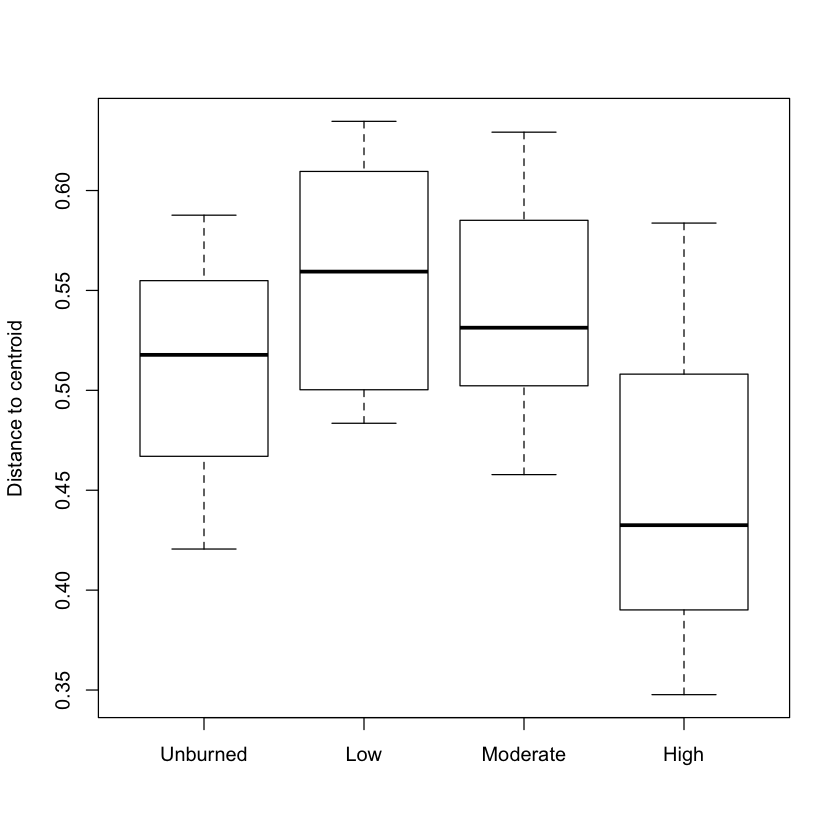

In [5]:
physeq = ps.hell
physeq = subset_samples(physeq,Land_Class=="Wetland")
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray", weighted=TRUE)
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Severity_Class)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here for the different vegetation communities - no significant differences.
# Looks generally okay for Severity_Class
# Land_Class barely not significant
# Mineral / Organic also have diff betadispersion - but not using as categorical (TC_pct)

In [7]:
AdonisFunction = function(physeq=ps.norm, method="bray", Org_or_Min=c("O","M"), Land_Class=c("Upland","Wetland")){
    #physeq = prune_samples(sample_data(physeq)$Burned_Unburned == "Burned", physeq)
    #physeq = prune_samples(sample_data(physeq)$Org_or_Min %in% Org_or_Min, physeq)
    physeq = prune_samples(sample_data(physeq)$Land_Class %in% Land_Class, physeq)
    physeq = prune_samples(!is.na(sample_data(physeq)$pH), physeq)
    #physeq = prune_samples(!is.na(sample_data(physeq)$TC_pct), physeq)
    #physeq = prune_samples(!is.na(sample_data(physeq)$Total_N_pct), physeq)
    #physeq = prune_samples(!is.na(sample_data(physeq)$Sand_pct), physeq)
    #physeq = prune_samples(!is.na(sample_data(physeq)$CFSI), physeq)
    d = distance(physeq, method = method, weighted=TRUE)  
    d.adonis = adonis(d ~ 
                      + sample_data(physeq)$Veg_Comm  
                      #+ sample_data(physeq)$Org_or_Min 
                      #+ sample_data(physeq)$Land_Class
                      #+ sample_data(physeq)$Sand_pct 
                      + sample_data(physeq)$pH
                      #+ sample_data(physeq)$Total_S_pct
                      #+ sample_data(physeq)$Al_mg_kg
                      #+ sample_data(physeq)$Exch_Ca_mg_kg
                      #+ sample_data(physeq)$Fire_ID
                      #+ sample_data(physeq)$TOC_LOI_pct
                      #+ sample_data(physeq)$CFSI
                      #+ sample_data(physeq)$CEC_cmol_kg
                      #+ sample_data(physeq)$P_mg_kg
                      #* sample_data(physeq)$Total_N_pct
                      + sample_data(physeq)$TC_pct
                      
                      + sample_data(physeq)$RBR_Cat
                      
                      + sample_data(physeq)$TC_pct*sample_data(physeq)$Veg_Comm  
                      + sample_data(physeq)$pH*sample_data(physeq)$Veg_Comm  
                      + sample_data(physeq)$TC_pct*sample_data(physeq)$pH
                      
                      + sample_data(physeq)$TC_pct * sample_data(physeq)$RBR_Cat
                      + sample_data(physeq)$pH * sample_data(physeq)$RBR_Cat
                      #+ sample_data(physeq)$Veg_Comm * sample_data(physeq)$RBR_Cat
                      
                      #+ sample_data(physeq)$Burned_Unburned                      
                      #+ sample_data(physeq)$RBR
                      #+ sample_data(physeq)$RBR_Cat
                      #+ sample_data(physeq)$fwi
                      #+ sample_data(physeq)$CFSI
                      #+ sample_data(physeq)$CBI
                      #+ sample_data(physeq)$Understory_CBI
                      #+ sample_data(physeq)$Overstory_CBI
                      #+ sample_data(physeq)$Burn_Severity_Index
                      #+ sample_data(physeq)$Severity_Class
                      #+ sample_data(physeq)$Surface_Severity_Class
                      #+ sample_data(physeq)$Pct_Exposed_Mineral
                      #+ sample_data(physeq)$Mean_Duff_Depth_cm
                      , df)
    d.adonis
}
# Try removing unburned sites from these models

In [8]:
AdonisFunction(Land_Class="Upland")
AdonisFunction(Land_Class="Wetland")
AdonisFunction()


Call:
adonis(formula = d ~ +sample_data(physeq)$Veg_Comm + sample_data(physeq)$pH +      sample_data(physeq)$TC_pct + sample_data(physeq)$RBR_Cat +      sample_data(physeq)$TC_pct * sample_data(physeq)$Veg_Comm +      sample_data(physeq)$pH * sample_data(physeq)$Veg_Comm + sample_data(physeq)$TC_pct *      sample_data(physeq)$pH + sample_data(physeq)$TC_pct * sample_data(physeq)$RBR_Cat +      sample_data(physeq)$pH * sample_data(physeq)$RBR_Cat, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                                        Df SumsOfSqs MeanSqs
sample_data(physeq)$Veg_Comm                             2    1.6608 0.83038
sample_data(physeq)$pH                                   1    0.9994 0.99940
sample_data(physeq)$TC_pct                               1    1.0059 1.00594
sample_data(physeq)$RBR_Cat                              3    2.3820 0.79400
sample_data(physeq)$Veg_Comm:sample_data(physeq)$TC_pct  2   


Call:
adonis(formula = d ~ +sample_data(physeq)$Veg_Comm + sample_data(physeq)$pH +      sample_data(physeq)$TC_pct + sample_data(physeq)$RBR_Cat +      sample_data(physeq)$TC_pct * sample_data(physeq)$Veg_Comm +      sample_data(physeq)$pH * sample_data(physeq)$Veg_Comm + sample_data(physeq)$TC_pct *      sample_data(physeq)$pH + sample_data(physeq)$TC_pct * sample_data(physeq)$RBR_Cat +      sample_data(physeq)$pH * sample_data(physeq)$RBR_Cat, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                                        Df SumsOfSqs MeanSqs
sample_data(physeq)$Veg_Comm                             1    1.2891 1.28908
sample_data(physeq)$pH                                   1    0.7915 0.79149
sample_data(physeq)$TC_pct                               1    0.3227 0.32266
sample_data(physeq)$RBR_Cat                              3    0.8836 0.29453
sample_data(physeq)$Veg_Comm:sample_data(physeq)$TC_pct  1   


Call:
adonis(formula = d ~ +sample_data(physeq)$Veg_Comm + sample_data(physeq)$pH +      sample_data(physeq)$TC_pct + sample_data(physeq)$RBR_Cat +      sample_data(physeq)$TC_pct * sample_data(physeq)$Veg_Comm +      sample_data(physeq)$pH * sample_data(physeq)$Veg_Comm + sample_data(physeq)$TC_pct *      sample_data(physeq)$pH + sample_data(physeq)$TC_pct * sample_data(physeq)$RBR_Cat +      sample_data(physeq)$pH * sample_data(physeq)$RBR_Cat, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                                        Df SumsOfSqs MeanSqs
sample_data(physeq)$Veg_Comm                             4     4.631 1.15786
sample_data(physeq)$pH                                   1     1.225 1.22505
sample_data(physeq)$TC_pct                               1     1.076 1.07625
sample_data(physeq)$RBR_Cat                              3     2.275 0.75842
sample_data(physeq)$Veg_Comm:sample_data(physeq)$TC_pct  4   

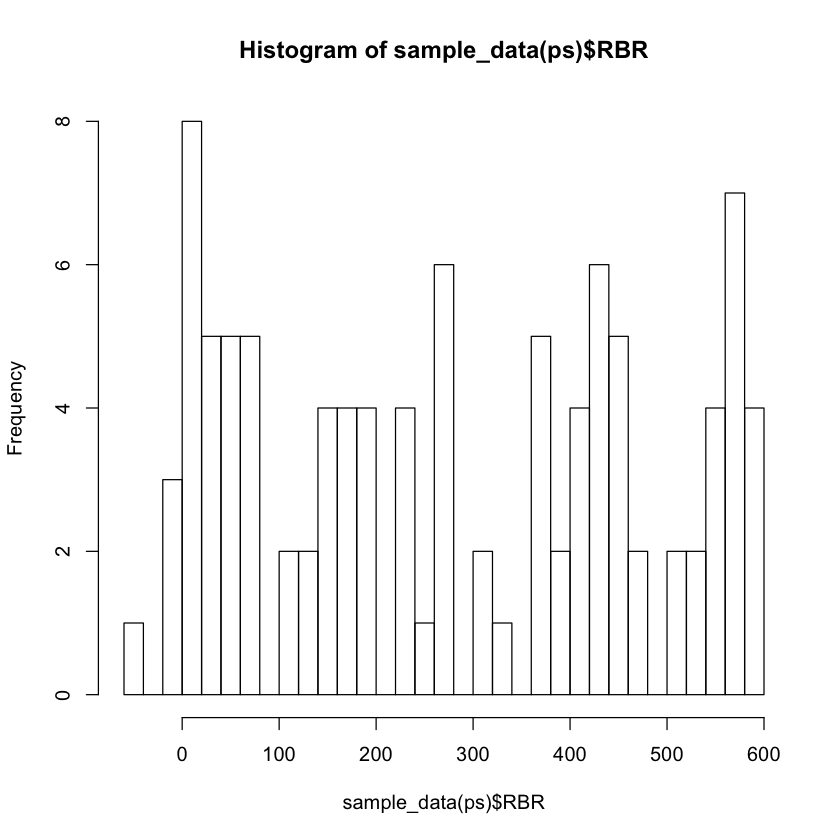

In [100]:
hist(sample_data(ps)$RBR,breaks=30)
# Good breaks: <100, <300, <500, >500

In [48]:
Up = AdonisFunction(Land_Class="Upland")
Wet = AdonisFunction(Land_Class="Wetland")
Both = AdonisFunction()

In [49]:
Up = data.frame(Up$aov.tab)
Wet = data.frame(Wet$aov.tab)
Both = data.frame(Both$aov.tab)
row.names(Up)=c("Plants","pH","Carbon","Severity Class","Plant-C","Plant-pH","pH-C","Severity-C","Severity-pH","Severity-Plants","Residuals","Total")
row.names(Wet)=c("Plants","pH","Carbon","Severity Class","Plant-C","Plant-pH","pH-C","Severity-C","Severity-pH","Residuals","Total")
row.names(Both)=c("Plants","pH","Carbon","Severity Class","Plant-C","Plant-pH","pH-C","Severity-C","Severity-pH","Severity-Plants","Residuals","Total")

In [51]:
Up

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.
Plants,2,1.6607526,0.8303763,2.6566378,0.05992133,0.001
pH,1,0.9994042,0.9994042,3.1974116,0.03605933,0.001
Carbon,1,1.0059430,1.0059430,3.2183313,0.03629526,0.001
Severity Class,3,2.2792441,0.7597480,2.4306754,0.08223702,0.001
Plant-C,2,0.7667461,0.3833731,1.2265323,0.02766484,0.114
Plant-pH,2,0.8786976,0.4393488,1.4056165,0.03170414,0.018
pH-C,1,0.4295740,0.4295740,1.3743439,0.01549939,0.051
Severity-C,3,0.6480420,0.2160140,0.6910974,0.02338189,0.996
Severity-pH,3,1.4441291,0.4813764,1.5400759,0.05210538,0.001
Severity-Plants,6,2.5998174,0.4333029,1.3862737,0.09380357,0.003
